In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
dengue_features_train = "dengue_features_train.csv"
dengue_labels_train = "dengue_labels_train.csv"

x_train = pd.read_csv(dengue_features_train, index_col=[0])
y_train = pd.read_csv(dengue_labels_train, index_col=[0])

# Seperate data for San Juan
sj_train_features = x_train.loc['sj']
sj_train_labels = y_train.loc['sj']

# Separate data for Iquitos
iq_train_features = x_train.loc['iq']
iq_train_labels = y_train.loc['iq']

In [3]:
#ax1 = sns.countplot(y_train['year'],label="Count")

In [4]:
#print (x_train.head)

In [5]:
output = ['total_cases']
weather_station_measurements =  ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c',
     'station_precip_mm', 'station_diur_temp_rng_c']

satellite_precipitation_measurements = ['precipitation_amt_mm']

climate_forcast_measurements = ['reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_k', 'reanalysis_air_temp_k', 
                          'reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg', 
                          'reanalysis_precip_amt_kg_per_m2', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 
                          'reanalysis_avg_temp_k', 'reanalysis_tdtr_k']

ndvi_columns = ['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']

all_data = pd.concat([sj_train_features, sj_train_labels], axis=1)

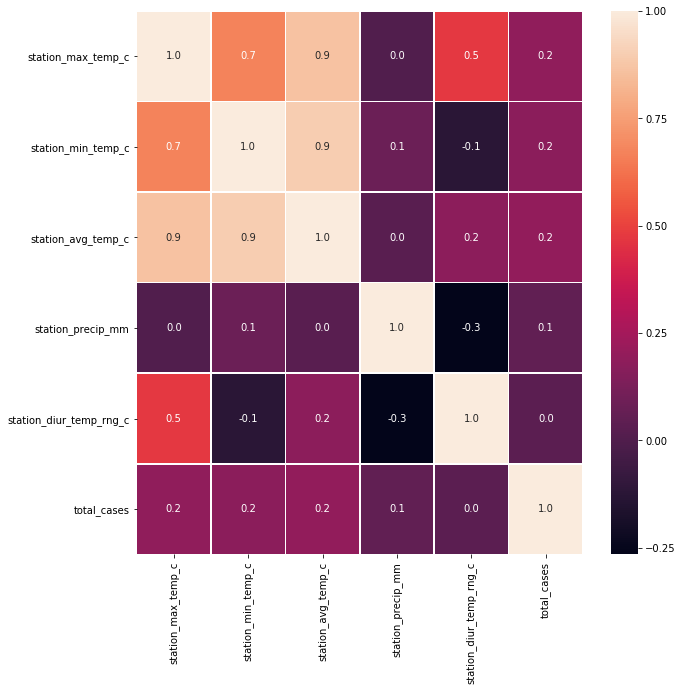

In [6]:
#corelation with weather measurements
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(all_data[weather_station_measurements +output].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

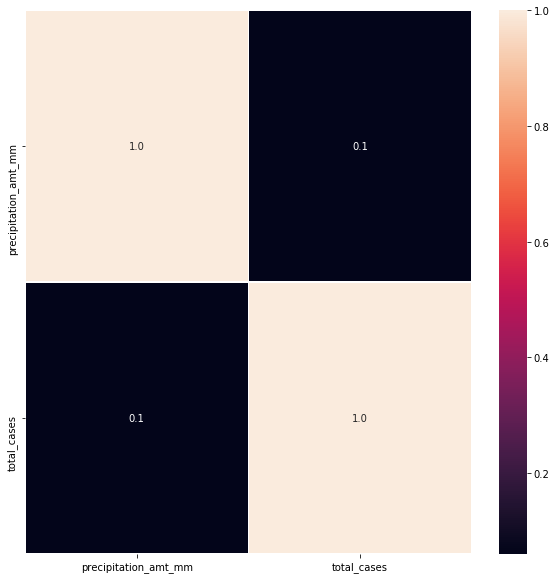

In [7]:
#corelation with satellite precipitation measurements
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(all_data[satellite_precipitation_measurements +output].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

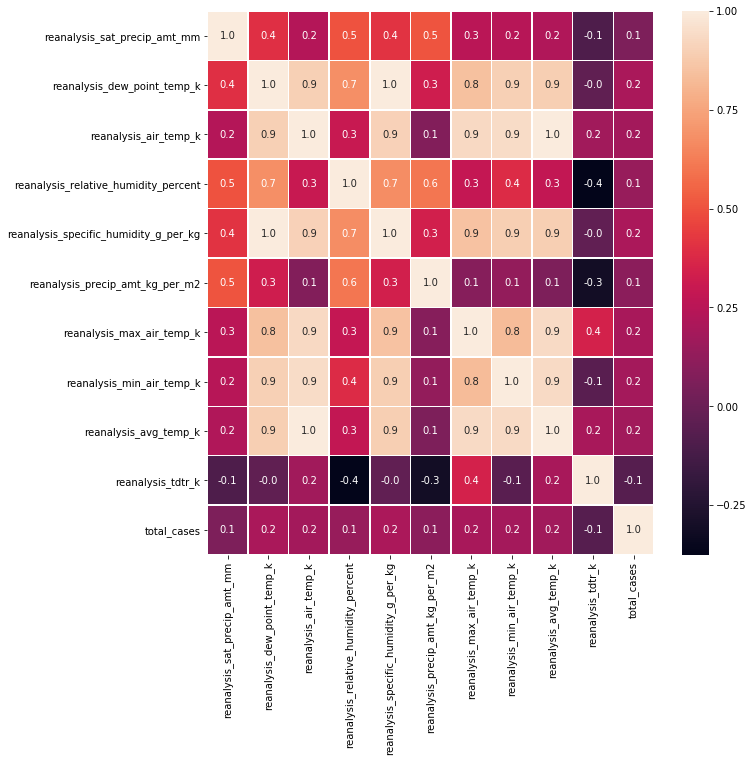

In [8]:
#corelation with climate forcast measurements
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(all_data[climate_forcast_measurements +output].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

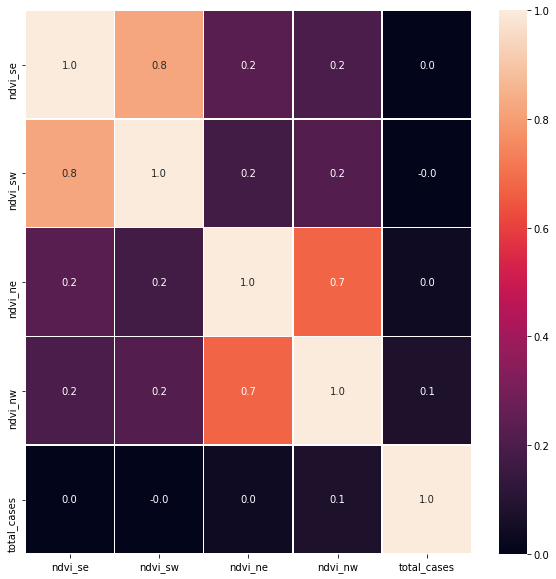

In [9]:
#corelation with ndvi columns
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(all_data[ndvi_columns +output].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [10]:
# correlation
# sj_train_features['total_cases'] = sj_train_labels.total_cases
# iq_train_features['total_cases'] = iq_train_labels.total_cases
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()


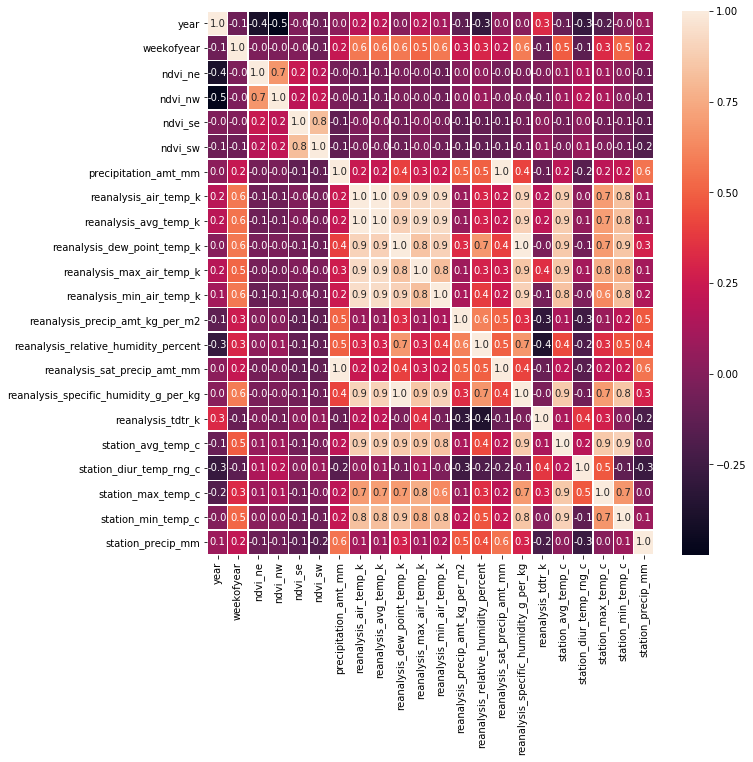

In [11]:
f,ax = plt.subplots(figsize=(10, 10))
sj_corr_heat = sns.heatmap(sj_correlations,annot=True, linewidths=.5, fmt= '.1f',ax=ax)


,year,weekofyear,total_cases
city,,,
sj,1990,18,4
sj,1990,19,5
sj,1990,20,4
sj,1990,21,3
sj,1990,22,6


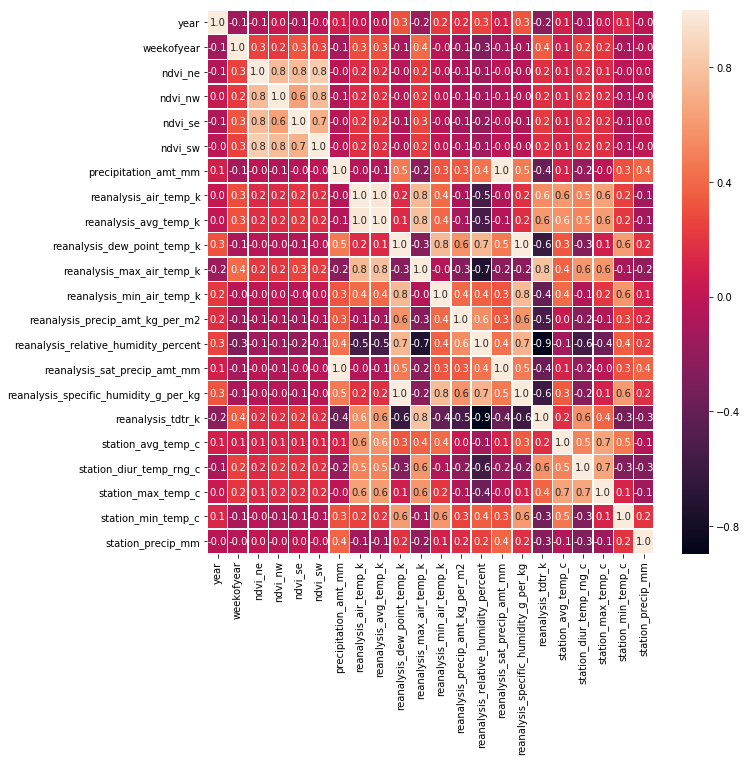

In [12]:
f,ax = plt.subplots(figsize=(10, 10))
iq_corr_heat = sns.heatmap(iq_correlations,annot=True, linewidths=.5, fmt= '.1f',ax=ax)
sj_train_labels.head()

In [13]:
from sklearn.preprocessing import Imputer
    
def formatX(x) :
    
    
    # Add new columns
    avg_ndvi = x[ndvi_columns].mean(axis=1)
    x['ndvi_avg'] = avg_ndvi
        
    # Drop irrelevant columns
    x = x.drop(['week_start_date'] + ndvi_columns + satellite_precipitation_measurements, axis=1)
    x = x.drop(['station_max_temp_c', 'station_min_temp_c'],axis=1)
    
    # Processing categoricals
    #One hot encoding categoricals
    x = pd.get_dummies(x)
    #without categoricals
    x = x.select_dtypes(exclude=['object'])
    
    #cols_with_missing = [col for col in x.columns if x[col].isnull().any()]
    #not_null_columns = [col for col in list(x.columns) if col not in cols_with_missing]
    
    #col_missing_X = x[cols_with_missing].copy()
    #my_imputer = Imputer()
    #temp_X = pd.DataFrame(my_imputer.fit_transform(col_missing_X))
    #x = pd.concat([x[not_null_columns], temp_X], axis=1)
    
    x.fillna(method='ffill', inplace=True)
    
    return x


def pre_process_sj(x):
    
    features = ['week_start_date',
                'reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c',
               'precipitation_amt_mm']
    x = x[features]
    
    x['week_start_date'] = pd.to_datetime(x['week_start_date'])
    for i in range(1,5):
        x['quarter_' + str(i)] = x['week_start_date'].apply(lambda date: 1 if (
            ((i-1)*3<date.to_datetime().month) and (date.to_datetime().month <= i * 3)) else 0)
        features.append('quarter_' + str(i))

    x = x.drop(['week_start_date','quarter_1','quarter_3',],axis=1)
#precipitation_amt_mm of week before last week
    i= x.iloc[-1:]
    j= x.precipitation_amt_mm
    j = j[:-1]
    col = []
    for k in i.precipitation_amt_mm:
        col.append(k)
    for k in j:
        col.append(k)
    x['pre_precipitation_amt_mm'] = col
    
    
    # fill missing values
    x.fillna(method='ffill', inplace=True)
    return x


def pre_process_iq(x):
    
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c']
    x = x[features]

    # fill missing values
    x.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    return x
   

In [14]:


sj_train_features_formated = pre_process_sj(sj_train_features)

iq_train_features_formated = pre_process_iq(iq_train_features)

# sj_train_features_formated.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/pandas/core/series.py:2551: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
def train(x_formated,y_train):
    # split data into training and validation data, for both predictors and target
    # The split is based on a random number generator. Supplying a numeric value to
    # the random_state argument guarantees we get the same split every time we
    # run this script.
    x, val_X, y, val_y = train_test_split(x_formated, y_train, test_size=0.1, random_state=0, shuffle=False)
    total_y = y[['total_cases'] ]
    total_y.fillna(method='ffill', inplace=True)
    forest_model = RandomForestRegressor(n_estimators=180,criterion='mae',max_depth=6,warm_start=True,)
    forest_model.fit(x, total_y)
    pred_val = forest_model.predict(val_X)
    print("MAE : " + str(mean_absolute_error(val_y['total_cases'], pred_val)))
    importances = forest_model.feature_importances_
    print (x.columns)
    print (importances)
    return forest_model

# print(sj_train_features_formated.head)
forest_model_sj = train(sj_train_features_formated,sj_train_labels)
forest_model_iq = train(iq_train_features_formated,iq_train_labels)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


MAE : 19.294178486997637
Index([u'reanalysis_specific_humidity_g_per_kg',
       u'reanalysis_dew_point_temp_k', u'station_avg_temp_c',
       u'precipitation_amt_mm', u'quarter_2', u'quarter_4',
       u'pre_precipitation_amt_mm'],
      dtype='object')
[0.15409221 0.14131823 0.1912379  0.09665567 0.11940255 0.18501982
 0.11227363]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


MAE : 4.871634615384615
Index([u'reanalysis_specific_humidity_g_per_kg',
       u'reanalysis_dew_point_temp_k', u'station_avg_temp_c'],
      dtype='object')
[0.28892941 0.34771544 0.36335516]


In [16]:
dengue_features_test = "dengue_features_test.csv"
x_test = pd.read_csv(dengue_features_test, index_col=[0])

sj_test_features = x_test.loc['sj']
iq_test_features = x_test.loc['iq']

# x_test.head()

sj_test_formated = pre_process_sj(sj_test_features)
iq_test_formated = pre_process_iq(iq_test_features)

sj_test_features.head()

pred_sj = pd.DataFrame(forest_model_sj.predict(sj_test_formated))
pred_sj = pred_sj.round().astype(int)
pred_sj.columns = ['total_cases']

# output_sj = pd.concat([sj_test_features[['city','year', 'weekofyear']], pred_sj], axis=1)

pred_iq = pd.DataFrame(forest_model_iq.predict(iq_test_formated))
pred_iq = pred_iq.round().astype(int)
pred_iq.columns = ['total_cases']

# output_iq = pd.concat([iq_test_features[['city','year', 'weekofyear']], pred_iq], axis=1)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:

submission = pd.read_csv("submission_format.csv")
print (submission.shape)
print (pred_sj.shape)
print (pred_iq.shape)
submission.total_cases = np.concatenate([pred_sj, pred_iq])
submission.to_csv("submission_1.1.csv",index=False)

(416, 4)
(260, 1)
(156, 1)
